<a href="https://colab.research.google.com/github/pedromiola28/Projeto_Controle_de_Vibracoes/blob/main/Projeto_Vibra%C3%A7oes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as  plt
import numpy as np
import pandas as pd
from scipy.linalg import eig
from scipy.optimize import minimize
from scipy import signal
import os

from google.colab import drive
drive.mount('/content/drive', force_remount = True)
path = r'/content/drive/My Drive/Vibrações/data'

Mounted at /content/drive


# **1) Descrever Modelo, encontrar $\mathbf{M}$, $\mathbf{K}$ e $\mathbf{f}$**

A proposta de um modelo discreto de múltiplos graus de liberdade para representar o modelo de prédio em escala descrito acima. (a) Descreva o modelo e apresente as matrizes de (b) massa, (c) rigidez e (d) o vetor de carregamentos.

---

## **a)**

O sistema é consituído pela estrutura, onde os três andares são suportados por 4 vigas. Podemos modelar o comportamento vibratório horizontal do sistema pelo comportamento elástico da viga, ou seja por meio de um sistema massa mola amortecedor (MMA)

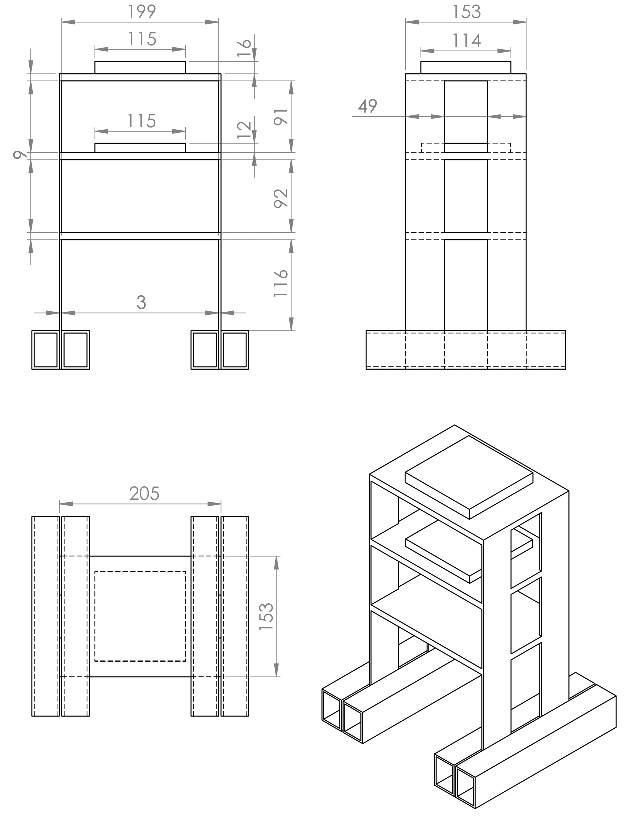

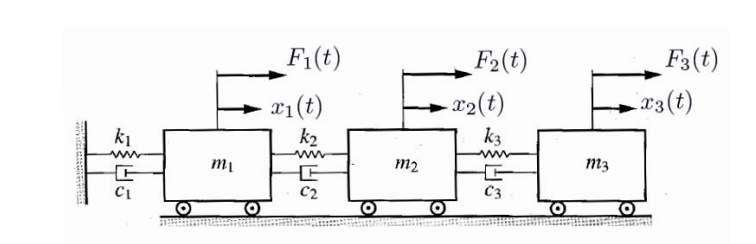

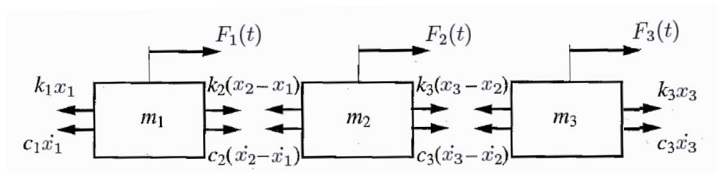

As equações para cada um dos andares 1, 2 e 3 são:

$$\begin{cases}
m_1\ddot{x}_1 = f_1 - k_1(x_1 - x_0) - c_1(\dot{x}_1 - \dot{x}_0)+k_2(x_2 - x_1) + c_2(\dot{x}_2 - \dot{x}_1)\\
m_2\ddot{x}_2 = f_2 - k_2(x_2 - x_1) - c_2(\dot{x}_2 - \dot{x}_1) + k_3(x_3 - x_2) + c_3(\dot{x}_3 - \dot{x}_2)\\
m_3\ddot{x}_3 = f_3 - k_3(x_3 - x_2) - c_3(\dot{x}_3 - \dot{x}_2)
\end{cases}$$

Juntando as equações, temos:

$$
\scriptstyle{\underbrace{\begin{bmatrix}
m_{1} & 0 & 0\\
0 & m_{2} & 0\\
0 & 0 & m_{3}
\end{bmatrix}}_{\mathbf{M}}\underbrace{\begin{Bmatrix}
\ddot{x}_{1}\\
\ddot{x}_{2}\\
\ddot{x}_{3}
\end{Bmatrix}}_{\ddot{\mathbf{x}}( t)} +\underbrace{\begin{bmatrix}
c_{1} +c_{2} & -c_{2} & 0\\
-c_{2} & c_{2} +c_{3} & -c_{3}\\
0 & -c_{3} & c_{3}
\end{bmatrix}}_{\mathbf{C}}\underbrace{\begin{Bmatrix}
\dot{x}_{1}\\
\dot{x}_{2}\\
\dot{x}_{3}
\end{Bmatrix}}_{\dot{\mathbf{x}}( t)} +\underbrace{\begin{bmatrix}
k_{1} +k_{2} & -k_{2} & 0\\
-k_{2} & k_{2} +k_{3} & -k_{3}\\
0 & -k_{3} & k_{3}
\end{bmatrix}}_{\mathbf{K}}\underbrace{\begin{Bmatrix}
x_{1}\\
x_{2}\\
x_{3}
\end{Bmatrix}}_{\mathbf{x}( t)} =\underbrace{\begin{Bmatrix}
f_{1} +c_{1}\dot{x}_{0} +k_{1} x_{0}\\
f_{2}\\
f_{3}
\end{Bmatrix}}_{\mathbf{F}( t)}}
$$


As medidadas indicadas na imagem seguem abaixo, junto com algumas propriedades do aço

In [ ]:
# Densidade [kg/m³]
rho = 7850
# Módulo de Elasticidade [Pa]
E = 210e+09
# Gravidade [m/s²]
g = 9.81

In [ ]:
# Largura, comprimento, espessura [m]
# Andar
w_a, l_a, t_a = .205, .153, .009
# Massa 3
w_m3, l_m3, t_m3 = .115, .114, .016
# Massa 2
w_m2, l_m2, t_m2 = .115, .113, .012
# Viga
w_v, t_v = .049, .003
h_v1, h_v2, h_v3 = .116, .092, .091

## **b)**

Devemos então calcular as propriedades do sistema MMA equivalente. As massas equivalentes devem carregar a mesma energia cinética que o sistema original, portanto a massa equivalente de cada andar será igual à massa do andar, mais a massa sobre ele, e mais a massa equivalente fletiva da viga.

$$
m_k = \rho\ w_k l_k t_k\\
m_{v_k,eq} = \frac{33}{140}m_{v_k}\\
\cases{
    m_1 = m_a + 4m_{v_1,eq}\\
    m_2 = m_a + m_{m_2} + 4m_{v_2,eq}\\
    m_3 = m_a + m_{m_3} + 4m_{v_3,eq}\\
}
$$

In [ ]:
# Massas 
m_a = rho * w_a * l_a * t_a
m_m3 = rho * w_m3 * l_m3 * t_m3
m_m2 = rho * w_m2 * l_m2 * t_m2
m_v1, m_v2, m_v3 = rho * w_v * t_v * np.array([h_v1, h_v2, h_v3])

m1 = m_a + 4*(33/140)*m_v1
m2 = m_a + m_m2 + 4*(33/140)*m_v2
m3 = m_a + m_m3 + 4*(33/140)*m_v3
M = np.diag([m1,m2,m3])
M

array([[2.34214641, 0.        , 0.        ],
       [0.        , 3.54016317, 0.        ],
       [0.        , 0.        , 3.96156216]])

$$\mathbf{M} =\begin{bmatrix}
m_{1} & 0 & 0\\
0 & m_{2} & 0\\
0 & 0 & m_{3}
\end{bmatrix} =\begin{bmatrix}
2.34 & 0 & 0\\
0 & 3.54 & 0\\
0 & 0 & 3.96
\end{bmatrix} \ kg$$

## **c)**

Já a rigidez de cada componente do sistema pode ser calculada a partir da linha elástica da viga

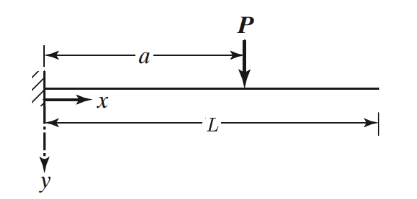

$$y(x) = \begin{cases}
\frac{Px^2}{6EI}(3a-x) , & 0\leqslant x\leqslant a\\
\frac{Pa^2}{6EI}(3x-a) , & a\leqslant x\leqslant L
\end{cases}\\
\frac{P}{y(x=a=L)} = k_{v} = \frac{3EI}{L^3}\\
I_v = \frac{w_v t_v^3}{12}\\
k_{v,k} = \sum_{j=1}^{4} \frac{3EI_v}{h_{v,k}^3}$$

In [ ]:
# Rigidez [N/m]
I = w_v * t_v**3 / 12
k1, k2, k3 = 4 * 3 * E * I / np.array([h_v1, h_v2, h_v3])**3
K = np.array([[k1+k2, -k2, 0],[-k2, k2+k3, -k3],[0, -k3, k3]])
np.round(K/1000,2)
np.round(np.array([k1, k2, k3])/1000,2)

array([177.99, 356.79, 368.68])

$$\mathbf{K} =\begin{bmatrix}
k_{1} +k_{2} & -k_{2} & 0\\
-k_{2} & k_{2} +k_{3} & -k_{3}\\
0 & -k_{3} & k_{3}
\end{bmatrix} =\begin{bmatrix}
534.79 & -356.79 & 0\\
-356.79 & 725.48 & -368.68\\
0 & -368.68 & 368.68
\end{bmatrix} \ kN/m
$$

## **d)**

O vetor de carregamentos representa a carga aplicada em cada andar, mas podemos aumentá-lo artificialmente pois estaremos interessados em um deslocameento da base $x_0(t)$, mas a FRF é obtida a partir da excitação no topo $f_3(t)$, portanto consideraremos $f_2=f_3=0$, e o vetor de carregamntos é dado por

$$\mathbf{F}(t) = \begin{Bmatrix}
c_{1}\dot{x}_{0}(t) +k_{1} x_{0}(t)\\ 0\\ f_{3}(t)
\end{Bmatrix}$$

# **2) Auto-decomposição - encontrar $\mathbf{U}$, $\omega_n$**

O cálculo das frequências naturais com base no modelo discreto e nos resultados experimentais fornecidos e as formas modais do sistema a partir do modelo discreto. (a) Mostre as  frequências naturais em forma de tabela, e (b) as formas modais na forma de gráficos que fornecem a amplitude de deslocamento de cada grau de liberdade (Sugestão: inclua um ponto  com deslocamento nulo para a base da estrutura para melhor visualização);

---

A vibração livre não amortecida pode ser modelada por

$$\mathbf{M\ddot{x}}(t) + \mathbf{Kx}(t) = \mathbf{0}$$

E aplicando a transformada de Fourier

$$(\mathbf{K} - \omega^2 \mathbf{M}) \tilde{\mathbf{x}} = \mathbf{0}$$

Portanto podemos achar $N$ autovalores $\omega_n$ e autovetores $\mathbf{u}_n$ que satisfaçam as equações

$$\cases{
    |\mathbf{K} - \omega_n^2 \mathbf{M}| = 0\\
    (\mathbf{K} - \omega_n^2 \mathbf{M})\mathbf{u}_n = 0\\
}$$

Onde $N=3$ é o número de graus de liberdade do sistema.

In [ ]:
Omega, U = eig(K,M)
Omega, U = Omega[::-1], U[:,::-1]
wn = np.sqrt(np.abs(Omega))
fn = wn / (2*np.pi)

## **a)**

In [ ]:
pd.DataFrame({"Modo":list(range(1,4)), "Frequência Natural [Hz]":np.round(fn,2)})

,Modo,Frequência Natural [Hz]
0,1,18.04
1,2,62.57
2,3,95.35


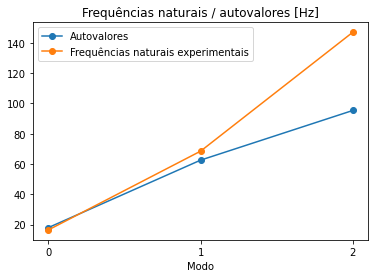

In [ ]:
fn_experimental = np.array([16.5, 68.5, 147])
plt.plot(fn, 'o-', label="Autovalores")
plt.plot(fn_experimental, 'o-', label="Frequências naturais experimentais")
plt.title("Frequências naturais / autovalores [Hz]")
plt.xlabel("Modo")
plt.xticks(range(3))
plt.legend();

## **b)**

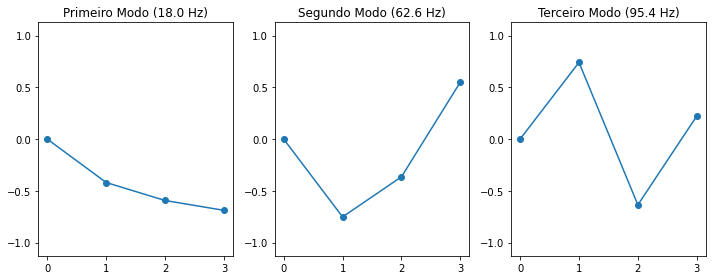

In [ ]:
lim = 1.5 * np.max(np.abs(U))
fig, axs = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    axs[i].set_title("{} Modo ({:.1f} Hz)".format(["Primeiro", "Segundo", "Terceiro"][i], fn[i]))
    axs[i].set_xticks(range(4));
    axs[i].plot([0]+list(U[:,i]), '-o')
    axs[i].set_ylim(-lim, lim)
fig.tight_layout()

# **3) Determinar amortecimento**

Com base nos resultados experimentais, determine o amortecimento do sistema (escolha o modelo de amortecimento que achar mais conveniente e justifique).

---

Utilizarmos o modelo de amortecimento proporcional
$$\mathbf{C} = \alpha \mathbf{M} + \beta \mathbf{K}\\
\mathbf{M\ddot{x}}(t) + \mathbf{C\dot{x}}(t) + \mathbf{Kx}(t) = \mathbf{F}(t)$$

E podemos representar o vetor de deslocamentos nas coordenadas dos autovetores

$$\mathbf{x}(t) = \overline{\mathbf{U}}\mathbf{q}(t)$$

Onde $\overline{\mathbf{U}}$ é a matriz de autovalores normalizados, para que possamos aplicar as propriedades de ortogonalidade. Veja que 

$$\mathbf{U}^{T}\mathbf{MU} =\begin{bmatrix}
m_{11} & 0 & \dotsc  & 0\\
0 & m_{22} & \dotsc  & 0\\
\vdots  & \vdots  & \ddots  & \vdots \\
0 & 0 & \dotsc  & m_{NN}
\end{bmatrix}$$

E os autovetors são normalizados pela relação

$$\overline{\mathbf{u}}_{i} =\frac{1}{\sqrt{m_{ii}}}\mathbf{u}_{i}\\
\overline{\mathbf{U}} =\begin{bmatrix}
\vdots  & \vdots  &  & \vdots \\
\overline{\mathbf{u}}_{1} & \overline{\mathbf{u}}_{2} & \dotsc  & \overline{\mathbf{u}}_{N}\\
\vdots  & \vdots  &  & \vdots 
\end{bmatrix}$$

De forma que valem as seguintes as propriedades de ortogonalidade

$$\begin{array}{ c c|c c }
\overline{\mathbf{U}}^{T}\mathbf{M}\overline{\mathbf{U}} =\mathbf{I} =\begin{bmatrix}
1 & 0 & \dotsc  & 0\\
0 & 1 & \dotsc  & 0\\
\vdots  & \vdots  & \ddots  & \vdots \\
0 & 0 & \dotsc  & 1
\end{bmatrix} &  &  & \overline{\mathbf{U}}^{T}\mathbf{K}\overline{\mathbf{U}} =\mathbf{\Omega } =\begin{bmatrix}
\omega _{1}^{2} & 0 & \dotsc  & 0\\
0 & \omega _{2}^{2} & \dotsc  & 0\\
\vdots  & \vdots  & \ddots  & \vdots \\
0 & 0 & \dotsc  & \omega _{N}^{2}
\end{bmatrix}
\end{array}
$$

Portanto podemos usar estas relaçõs para desacoplar as equações do movimento

Substituindo $\mathbf{x}(t)=\overline{\mathbf{U}}\mathbf{q}(t)$ e $\mathbf{C}=\alpha\mathbf{M}+\beta \mathbf{K}$ na equação do movimento $\mathbf{M\ddot{x}}(t) + \mathbf{C\dot{x}}(t) + \mathbf{Kx}(t) = \mathbf{F}(t)$, e multiplicando-a pela esquerda por $\mathbf{\overline{\mathbf{U}}}^T$ teremos

$$\underbrace{\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{M}\overline{\mathbf{U}}}_{\mathbf{I}}\ddot{\mathbf{q}}( t) +\left( \alpha \underbrace{\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{M}\overline{\mathbf{U}}}_{\mathbf{I}} +\beta \underbrace{\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{K\overline{\mathbf{U}}}}_{\mathbf{\Omega }}\right)\dot{\mathbf{q}}( t) +\mathbf{\underbrace{\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{K\overline{\mathbf{U}}}}_{\mathbf{\Omega }} q}( t) =\underbrace{\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{f}}_{\mathbf{Q}( t)}$$

Onde $\mathbf{Q}(t) = \mathbf{\overline{\mathbf{U}}}^{T}\mathbf{f}(t)$ é o vetor de forças nas coordenadas dos autovetores. Perceba que como ambas as matrizes $\mathbf{I}$ e $\mathbf{\Omega}$ são diagonais, as equações estão desacopladas, e cada uma de suas componentes é dada por

$$\ddot{q}_{k}( t) +\left( \alpha +\beta \omega _{k}^{2}\right)\dot{q}_{k}( t) +\omega _{k}^{2} q_{k}( t) =Q_{k}(t)$$

Que é uma equação diferencial ordinária de segunda ordem, e portanta pode ser representada por

$$\ddot{q}_{k}( t) +2\omega _{k} \xi _{k}\dot{q}_{k}( t) +\omega _{k}^{2} q_{k}( t) =Q_{k}( t)$$

Que nos dá a relação

$$\alpha +\beta \omega _{k}^{2} =2\xi _{k} \omega _{k}$$

Mas no nosso caso usaremos o mesmo $\xi_k=\xi$ para todos os andares, e este deverá ser o parâmetro a ser ajustado.

Tendo encontrardo $\xi$, podemos voltar e determinar a matriz $\mathbf{C}$

$$\mathbf{C} =\alpha \mathbf{M} +\beta \mathbf{K}\\
\overline{\mathbf{U}}^{T}\mathbf{C}\overline{\mathbf{U}} =\alpha \underbrace{\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{M}\overline{\mathbf{U}}}_{\mathbf{I}} +\beta \underbrace{\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{K}\overline{\mathbf{U}}}_{\mathbf{\Omega }} =\begin{bmatrix}
\alpha +\beta \omega _{1}^{2} & 0 & 0\\
0 & \alpha +\beta \omega _{2}^{2} & 0\\
0 & 0 & \alpha +\beta \omega _{3}^{2}
\end{bmatrix}$$

In [ ]:
data = [pd.read_csv(os.path.join(path,f"{i+1}fl.csv")) for i in range(3)] # [g/N]
A_exp = g * np.array([data[i].Re + 1j * data[i].Im for i in range(3)])    # [m/s².N]
freqs_exp = np.arange(0,1025,1)
freqs_frf = np.arange(0,300,0.5)
# Truncar dados para analisar apenas o intervalo de interesse
A_exp, freqs_exp = A_exp[:,:301], freqs_exp[:301]

In [ ]:
#Calculo do amortecimento através da banda de meia potencia. Calculos feitos a mão e inseridos no código.
w_esq = np.array([16.5,68.14,145.1])
w_dir = np.array([18.5,70.3,149.5])
ksi = np.array([0.05555,0.01542,0.01486])

In [ ]:
U_norm = U / np.sqrt(np.diag(U.T @ M @ U))
C = 2* np.diag(ksi) @ np.linalg.inv(U_norm.T) @ np.diag(wn) @ np.linalg.inv(U_norm)
C
c1, c2, c3 = C[0][0] + C[0][1], -C[0][1], C[2][2]
np.round(C,2)

array([[117.49, -48.83, -11.53],
       [-13.55,  43.19, -18.3 ],
       [ -3.08, -17.64,  30.43]])

Mas definimos $\alpha +\beta \omega _{k}^{2} \equiv 2\xi _{k} \omega _{k}$, portanto

$$\mathbf{C} =2\xi\overline{\mathbf{U}}^{-T}\mathbf{\Omega}\overline{\mathbf{U}}^{-1}\\
\mathbf{C} =\begin{bmatrix}
117.5 & -48.84 & -11.53\\
-13.55 & 43.19 & -18.3\\
-3.08 & -17.64 & 30.43
\end{bmatrix} \ N.s/m$$

# **4) Calcular e plotar FRF ($\tilde{\mathbf{H}}(\omega), \tilde{\mathbf{A}}(\omega)$)**

Calcule a FRF associada a resposta em aceleração do $i$-ésimo andar da estrutura quando uma excitação  é aplicada no $j$-ésimo andar para a faixa de frequência de 0 - 300 Hz (∆f = 0.5 Hz). No mesmo gráfico, mostre a curva experimental obtida (pontos de resposta/excitação serão fornecidos via Moodle para cada dupla).

---

Partindo da equação
$$\ddot{q}_{k}( t) +2\omega _{k} \xi _{k}\dot{q}_{k}( t) +\omega _{k}^{2} q_{k}( t) =Q_{k}( t)$$

Podemos aplicar a transformada de Fourier para encontrar as funções de transferência

$$-\omega ^{2}\tilde{q}_{k}( \omega ) +i2\xi _{k} \omega _{k} \omega \tilde{q}_{k}( \omega ) +\omega _{k}^{2}\tilde{q}_{k}( \omega ) =\tilde{Q}_{k}( \omega )\\
\tilde{q}_{k}( \omega ) =\frac{\tilde{Q}_{k}( \omega )}{\omega _{k}^{2} -\omega ^{2} +i2\xi _{k} \omega _{k} \omega }\\
\mathbf{\tilde{q}}( \omega ) =\underset{k=1}{\overset{N}{\mathrm{diag}}}\left(\frac{1}{\omega _{k}^{2} -\omega ^{2} +i2\xi _{k} \omega _{k} \omega }\right)\mathbf{\tilde{Q}}( \omega )$$

Onde podemos considerar entradas e saídas harmônicas para expressar $\mathbf{q}( t)\mathbf{=\tilde{q}}( \omega ) e^{i\omega t}$ e $\mathbf{Q}( t)\mathbf{=\tilde{Q}}( \omega ) e^{i\omega t}$, e substituir $\mathbf{q}(t)\mathbf{=\overline{\mathbf{U}}}^{-1}\mathbf{x}(t)$ e $\mathbf{Q}(t) =\mathbf{\overline{\mathbf{U}}}^T\mathbf{f}(t)$ de onde tiramos

$$\mathbf{\overline{\mathbf{U}}}^{-1}\mathbf{x}( t) \ e^{-i\omega t} =\underset{k=1}{\overset{N}{\mathrm{diag}}}\left(\frac{1}{\omega _{k}^{2} -\omega ^{2} +i2\xi _{k} \omega _{k} \omega }\right)\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{f}( t) \ e^{-i\omega t}\\
\mathbf{x}( t) =\mathbf{\overline{\mathbf{U}}} \ \underset{k=1}{\overset{N}{\mathrm{diag}}}\left(\frac{1}{\omega _{k}^{2} -\omega ^{2} +i2\xi _{k} \omega _{k} \omega }\right)\mathbf{\overline{\mathbf{U}}}^{T}\mathbf{f}( t)$$

E portanto uma função resposta na frequência matricial

$$\tilde{\mathbf{H}}( \omega ) =\mathbf{\overline{\mathbf{U}}} \ \underset{k=1}{\overset{N}{\mathrm{diag}}}\left(\frac{1}{\omega _{k}^{2} -\omega ^{2} +i2\xi _{k} \omega _{k} \omega }\right)\mathbf{\overline{\mathbf{U}}}^{T}$$

Mas estamos buscando a acelerância do sistema, portanto

$$\begin{array}{ c c c c c }
\mathbf{a}( t) =\ddot{\mathbf{x}}( t) &  & \overset{\mathcal{F}}{\Longrightarrow } &  & \tilde{\mathbf{a}}( \omega ) =-\omega ^{2}\tilde{\mathbf{x}}( \omega )\\
 &  &  &  & \Downarrow \\
\begin{cases}
\tilde{H}( \omega ) =\tfrac{\tilde{x}( \omega )}{\tilde{f}( \omega )}\\
\tilde{A}( \omega ) =\tfrac{\tilde{a}( \omega )}{\tilde{f}( \omega )}
\end{cases} &  & \Longrightarrow  &  & \tilde{\mathbf{A}}( \omega ) =-\omega ^{2}\tilde{\mathbf{H}}( \omega )
\end{array}$$

E

$$\tilde{\mathbf{A}}( \omega ) =\begin{bmatrix}
\tilde{A}_{11}( \omega ) & \tilde{A}_{12}( \omega ) & \tilde{A}_{13}( \omega )\\
\tilde{A}_{21}( \omega ) & \tilde{A}_{22}( \omega ) & \tilde{A}_{23}( \omega )\\
\tilde{A}_{31}( \omega ) & \tilde{A}_{32}( \omega ) & \tilde{A}_{33}( \omega )
\end{bmatrix}$$

Onde $\tilde{A}_{ij}(\omega)$ associa a resposta em aceleração do $i$-ésimo andar ($x_i$) quando uma excitação é aplicada no $j$-ésimo andar ($f_j$)


In [ ]:
def H_fnc(w):
    A_qQ = np.diag([1 / (wn[k]**2 - w**2 - 2j*ksi[k]*wn[k]*w) for k in range(3)])
    return U_norm @ A_qQ @ U_norm.T

def A_fnc(w):
    return -w**2 * H_fnc(w)

A = np.array([A_fnc(w) for w in 2*np.pi*freqs_frf])
A = np.swapaxes(np.swapaxes(A,0,2),0,1)

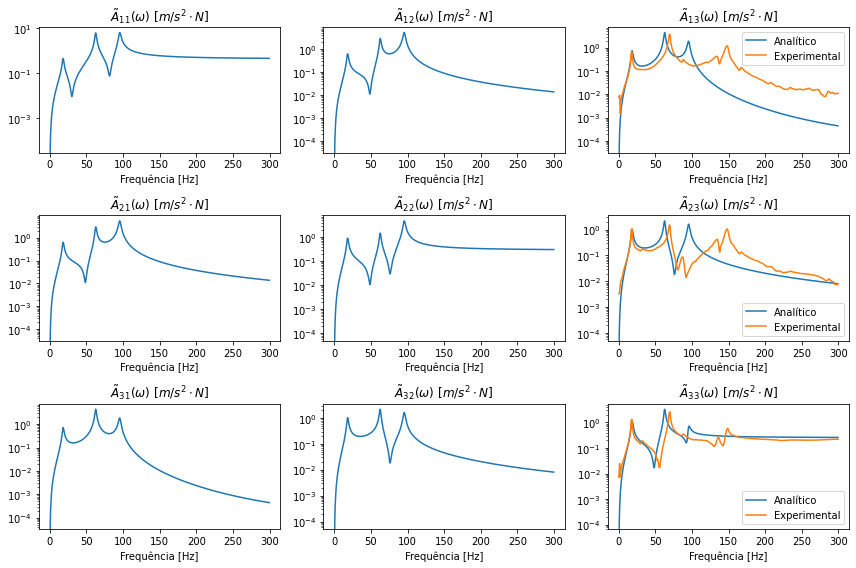

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(12,8))
for i in range(3):      # xi
    for j in range(3):  # fj
        axs[i][j].set_title(r"$\tilde{A}_{%s %s}(\omega)\ [m/s^2\cdot N]$"%(i+1,j+1))
        axs[i][j].semilogy(freqs_frf, np.abs(A[i][j]), label="Analítico")
        axs[i][j].set_xlabel("Frequência [Hz]")
for i in range(3):      # xi
    axs[i][2].semilogy(freqs_exp, np.abs(A_exp[i]), label="Experimental")
    axs[i][2].legend()

plt.tight_layout()

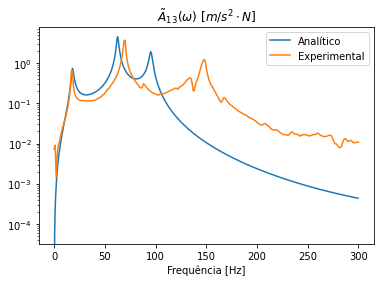

In [ ]:
plt.title(r"$\tilde{A}_{13}(\omega)\ [m/s^2\cdot N]$")
plt.semilogy(freqs_frf, np.abs(A[0][2]), label="Analítico")
plt.semilogy(freqs_exp, np.abs(A_exp[0]), label="Experimental")
plt.xlabel("Frequência [Hz]")
plt.legend()
plt.savefig("A13.png")

# **5) Verificar validade do modelo**

Seu modelo está em concordância com o resultado experimental? Proponha e implemente ajustes que melhorem a concordância entre os dois resultados, justificando-os.

---



In [ ]:
# Rigidez [N/m]
fn_experimental = np.array([16.5, 68.5, 147])
erro1 = []
erro2 = []
erro3 = []
fn_valores = []
wn_valores = []
for fator in range(30, 120):
  I = w_v * t_v**3 / 12
  k1, k2, k3 = 4 * fator/10 * E * I / np.array([h_v1, h_v2, h_v3])**3
  K = np.array([[k1+k2, -k2, 0],[-k2, k2+k3, -k3],[0, -k3, k3]])
  np.round(K/1000,2)
  np.round(np.array([k1, k2, k3])/1000,2)
  Omega, U = eig(K,M)
  Omega, U = Omega[::-1], U[:,::-1]
  wn = np.sqrt(np.abs(Omega))
  fn = wn / (2*np.pi)
  fn = fn*np.sqrt(1-ksi**2)
  fn_valores.append(fn)
  erro1.append(abs(fn[0]-fn_experimental[0]))
  erro2.append(abs(fn[1]-fn_experimental[1]))
  erro3.append(abs(fn[2]-fn_experimental[2]))

In [ ]:
ind1, ind2, ind3 = erro1.index(min(erro1)), erro2.index(min(erro2)), erro3.index(min(erro3))

In [ ]:
fn[0], fn[1], fn[2] = fn_valores[ind1][0], fn_valores[ind2][1], fn_valores[ind3][2]
wn = (fn/(np.sqrt(1-ksi**2)))*2*np.pi

In [ ]:
fn

array([ 18.01392504,  68.52946582, 146.67265771])

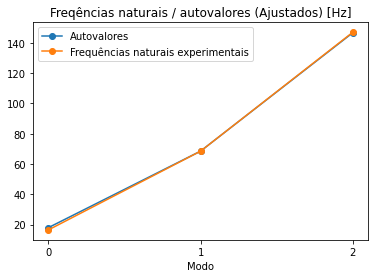

In [ ]:
plt.plot(fn, 'o-', label="Autovalores")
plt.plot(fn_experimental, 'o-', label="Frequências naturais experimentais")
plt.title("Freqências naturais / autovalores (Ajustados) [Hz]")
plt.xlabel("Modo")
plt.xticks(range(3))
plt.legend();

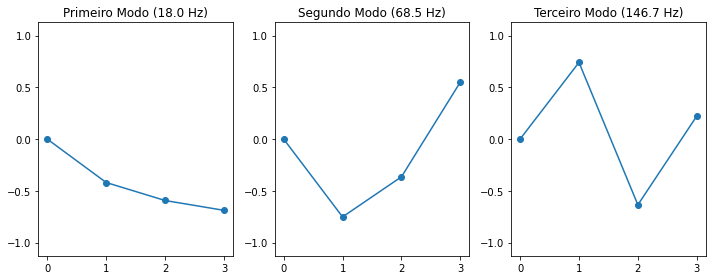

In [ ]:
lim = 1.5 * np.max(np.abs(U))
fig, axs = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    axs[i].set_title("{} Modo ({:.1f} Hz)".format(["Primeiro", "Segundo", "Terceiro"][i], fn[i]))
    axs[i].set_xticks(range(4));
    axs[i].plot([0]+list(U[:,i]), '-o')
    axs[i].set_ylim(-lim, lim)
fig.tight_layout()

In [ ]:
def H_fnc(w):
    A_qQ = np.diag([1 / (wn[k]**2 - w**2 - 2j*ksi[k]*wn[k]*w) for k in range(3)])
    return U_norm @ A_qQ @ U_norm.T

def A_fnc(w):
    return -w**2 * H_fnc(w)

A = np.array([A_fnc(w) for w in 2*np.pi*freqs_frf])
A = np.swapaxes(np.swapaxes(A,0,2),0,1)

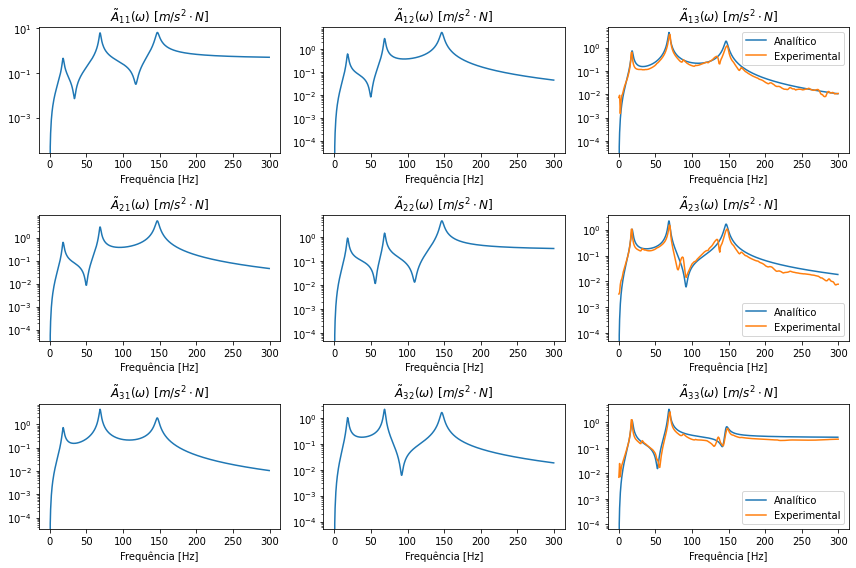

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(12,8))
for i in range(3):      # xi
    for j in range(3):  # fj
        axs[i][j].set_title(r"$\tilde{A}_{%s %s}(\omega)\ [m/s^2\cdot N]$"%(i+1,j+1))
        axs[i][j].semilogy(freqs_frf, np.abs(A[i][j]), label="Analítico")
        axs[i][j].set_xlabel("Frequência [Hz]")
for i in range(3):      # xi
    axs[i][2].semilogy(freqs_exp, np.abs(A_exp[i]), label="Experimental")
    axs[i][2].legend()

plt.tight_layout()

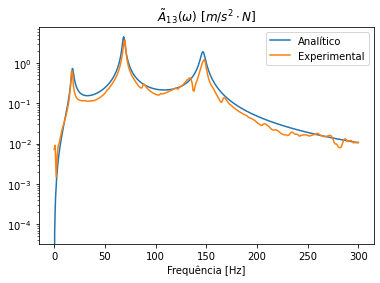

In [ ]:
plt.title(r"$\tilde{A}_{13}(\omega)\ [m/s^2\cdot N]$")
plt.semilogy(freqs_frf, np.abs(A[0][2]), label="Analítico")
plt.semilogy(freqs_exp, np.abs(A_exp[0]), label="Experimental")
plt.xlabel("Frequência [Hz]")
plt.legend()
plt.savefig("A13.png")

# **6) Calcular resposta para excitação na base $(x_0(t) \rightarrow \mathbf{x}(t))$**

Calcule a resposta de todos os andares quando a excitação periódica fornecedida  é aplicada a base da estrutura. Mostre os resultados em termos do espectro de magnitude e no tempo considerando os primeiros 20 termos. Qual o nível de vibração obtido em cada andar (valor RMS global em dB)? (Obs.: A=0.40 mm e 𝜏 = 0.045 s)

---

Lembre que generalizamos o vetor de forças para permitir a excitação da base da estrutura, de forma que 

$$\mathbf{f}( t) =\begin{Bmatrix}
c_{1}\dot{x}_{0}( t) +k_{1} x_{0}( t)\\
0\\
f_{3}( t)
\end{Bmatrix}
$$

Portanto neste caso consideraremos $f_3(t)=0$, e como usaremos $\tilde{\mathbf{f}}(\omega)$ para encontrar $\mathbf{x}(t)$ a partir da relação

$$\tilde{\mathbf{x}}(\omega) =\tilde{\mathbf{H}}(\omega) \ \tilde{\mathbf{f}}(\omega)$$

Então podemos determinar

$$\tilde{\mathbf{f}}( \omega ) =\begin{Bmatrix}
\left( k_{1} +i\omega c_{1}\right)\tilde{x}_{0}( \omega ) & 0 & 0
\end{Bmatrix}^{T}$$

In [ ]:
tau  = 0.045 # s
Amp = 4.0e-04  # m
T = 3*tau
t = np.linspace(0,T,20)
x0 = 2*Amp*np.abs(t/tau-np.floor(t/tau+1/2))
freqs_tri = np.fft.fftfreq(t.size, d=t[1]-t[0])
w = 2*np.pi*freqs_tri
xt_0 = np.fft.fft(x0)

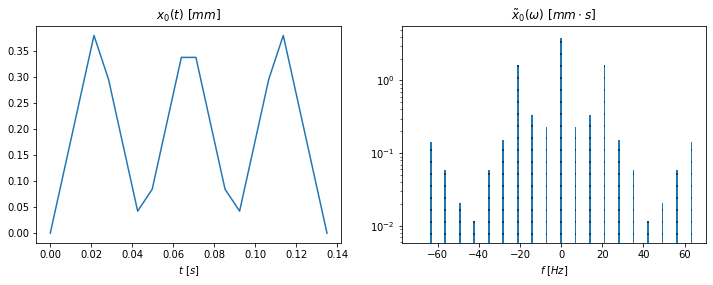

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(t, 1000*x0)
axs[0].set_xlabel(r"$t\ [s]$")
axs[0].set_title(r"$x_0(t)\ [mm]$")
axs[1].bar(freqs_tri, 1000*np.abs(xt_0), log=True, hatch='-')
axs[1].set_xlabel(r"$f\ [Hz]$")
axs[1].set_title(r"$\tilde{x}_0(\omega)\ [mm\cdot s]$");
axs[1].set_ylim(sorted(1000*np.abs(xt_0))[1]*.5, 1.5*np.max(1000*np.abs(xt_0)));

In [ ]:
xt_resp = np.array([ H_fnc(w) @ [(k1 + 1j*c1*w)*xt_0[k],0,0] for k,w in enumerate(2*np.pi*freqs_tri)])
x_resp = np.array([np.real(np.fft.ifft(xt_resp[:,k])) for k in range(3)])

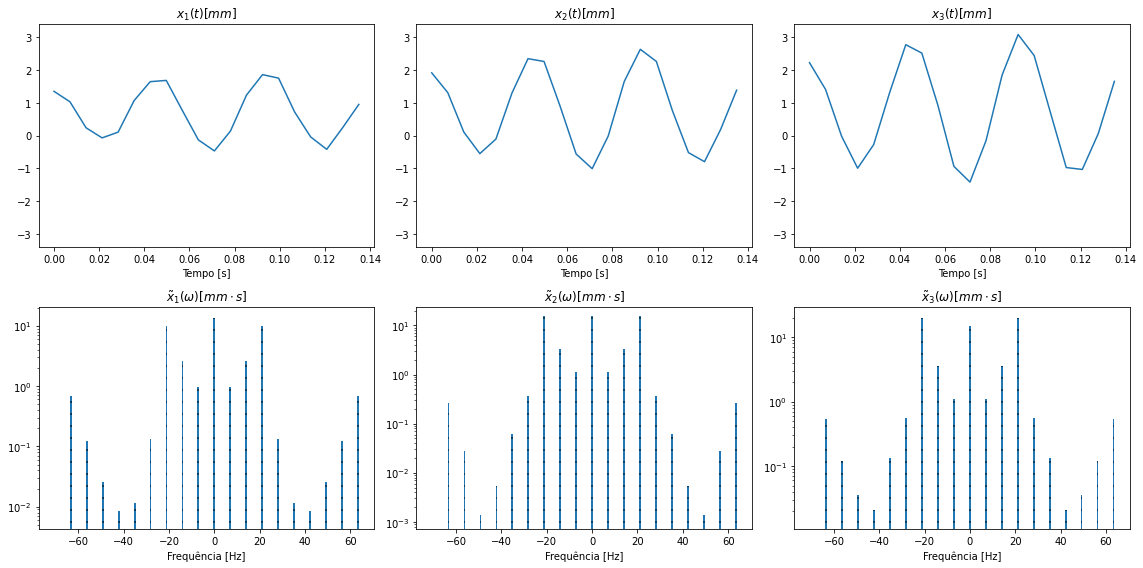

In [ ]:
lim = 1.1 * 1000 * np.max(np.abs(x_resp))
fig, axs = plt.subplots(2,3,figsize=(16,8))
for i in range(3):
    axs[0][i].plot(t, 1000*x_resp[i])
    axs[0][i].set_title(r"$x_%s(t) [mm]$" % (i+1))
    axs[0][i].set_xlabel("Tempo [s]")
    axs[0][i].set_ylim(-lim, lim)
for i in range(3):
    axs[1][i].bar(freqs_tri, 1000*np.abs(xt_resp[:,i]), log=True, hatch='-')
    axs[1][i].semilogy()
    axs[1][i].set_title(r"$\tilde{x}_%s(\omega) [mm\cdot s]$" % (i+1))
    axs[1][i].set_xlabel("Frequência [Hz]")
    axs[1][i].set_ylim(sorted(1000*np.abs(xt_resp[:,i]))[1]*0.5,1.5*np.max(1000*np.abs(xt_resp[:,i])));
fig.tight_layout()

In [ ]:
rms = np.sqrt(np.mean(x_resp**2,axis=1))
pd.DataFrame({"Andar":range(1,4), "RMS xi [mm]":np.round(1000*rms,2)})

,Andar,RMS xi [mm]
0,1,1.01
1,2,1.39
2,3,1.61


In [ ]:
rms

array([0.00100592, 0.00138597, 0.00160918])

In [ ]:
x_ref = 0.001 #1mm como referência
rms = 20*np.log10(rms/x_ref)
rms

array([0.05124861, 2.83510481, 4.13211708])

# **7) Discutir resultados, propor diminuição de vibração**

7. Discuta os resultados e proponha formas de reduzir a vibração (valor RMS global) em um andar a ser indicado pelos monitores. Avalie as propostas através do modelo, comparando com os resultados anteriores.

---

In [ ]:
# Aumento de Rigidez [N/m]
fn_experimental = np.array([16.5, 68.5, 147])
K = K*1.2
np.round(K/1000,2)
np.round(np.array([k1, k2, k3])/1000,2)
Omega, U = eig(K,M)
Omega, U = Omega[::-1], U[:,::-1]
wn = np.sqrt(np.abs(Omega))
fn = wn / (2*np.pi)
fn = fn*np.sqrt(1-ksi**2)

In [ ]:
xt_resp = np.array([ H_fnc(w) @ [(k1 + 1j*c1*w)*xt_0[k],0,0] for k,w in enumerate(2*np.pi*freqs_tri)])
x_resp = np.array([np.real(np.fft.ifft(xt_resp[:,k])) for k in range(3)])

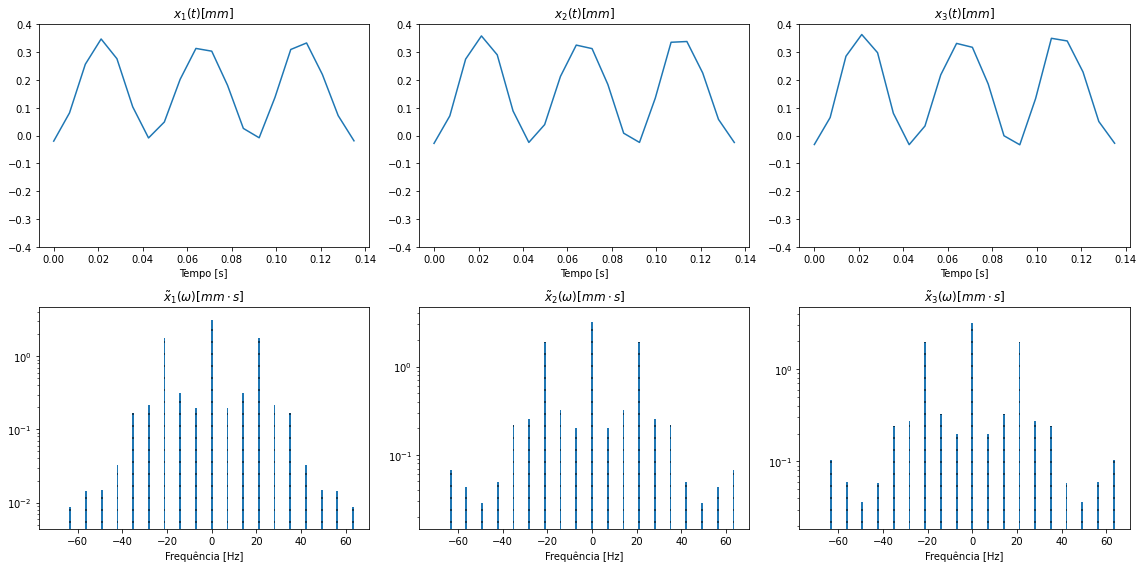

In [ ]:
lim = 1.1 * 1000 * np.max(np.abs(x_resp))
fig, axs = plt.subplots(2,3,figsize=(16,8))
for i in range(3):
    axs[0][i].plot(t, 1000*x_resp[i])
    axs[0][i].set_title(r"$x_%s(t) [mm]$" % (i+1))
    axs[0][i].set_xlabel("Tempo [s]")
    axs[0][i].set_ylim(-lim, lim)
for i in range(3):
    axs[1][i].bar(freqs_tri, 1000*np.abs(xt_resp[:,i]), log=True, hatch='-')
    axs[1][i].semilogy()
    axs[1][i].set_title(r"$\tilde{x}_%s(\omega) [mm\cdot s]$" % (i+1))
    axs[1][i].set_xlabel("Frequência [Hz]")
    axs[1][i].set_ylim(sorted(1000*np.abs(xt_resp[:,i]))[1]*0.5,1.5*np.max(1000*np.abs(xt_resp[:,i])));
fig.tight_layout()

In [ ]:
rms = np.sqrt(np.mean(x_resp**2,axis=1))
pd.DataFrame({"Andar":range(1,4), "RMS xi [mm]":np.round(1000*rms,2)})

,Andar,RMS xi [mm]
0,1,0.20
1,2,0.21
2,3,0.21


In [ ]:
x_ref = 0.001 #1mm como referência
rms = 20*np.log10(rms/x_ref)
rms

array([-13.82968894, -13.52359241, -13.35917694])

In [ ]:
#Aumento de massa
fn_experimental = np.array([16.5, 68.5, 147])
K = K/1.2
M = M*1.2
np.round(K/1000,2)
np.round(np.array([k1, k2, k3])/1000,2)
Omega, U = eig(K,M)
Omega, U = Omega[::-1], U[:,::-1]
wn = np.sqrt(np.abs(Omega))
fn = wn / (2*np.pi)
fn = fn*np.sqrt(1-ksi**2)

In [ ]:
xt_resp = np.array([ H_fnc(w) @ [(k1 + 1j*c1*w)*xt_0[k],0,0] for k,w in enumerate(2*np.pi*freqs_tri)])
x_resp = np.array([np.real(np.fft.ifft(xt_resp[:,k])) for k in range(3)])

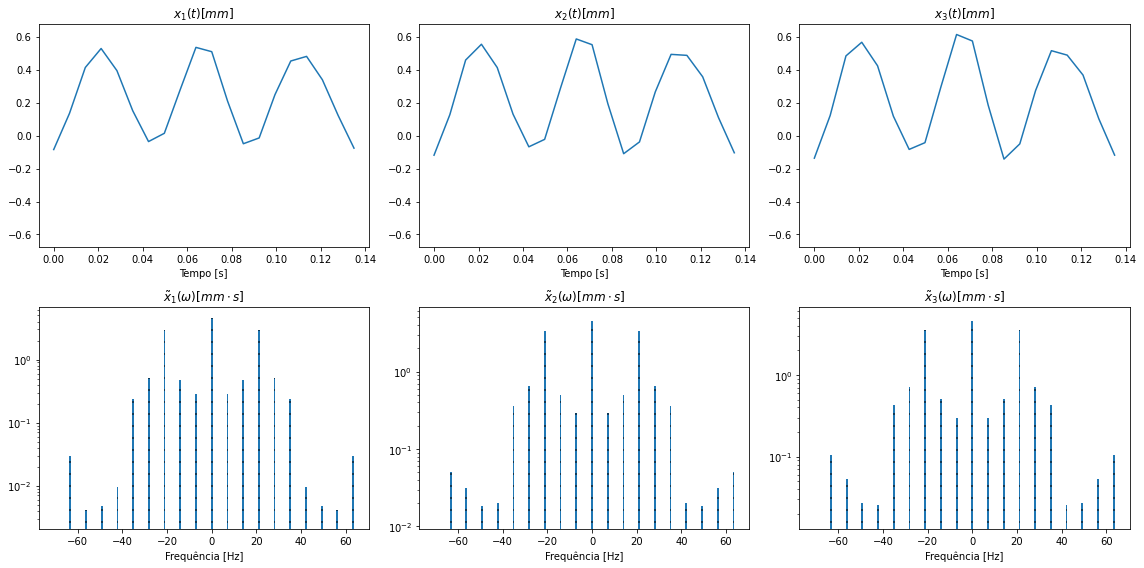

In [ ]:
lim = 1.1 * 1000 * np.max(np.abs(x_resp))
fig, axs = plt.subplots(2,3,figsize=(16,8))
for i in range(3):
    axs[0][i].plot(t, 1000*x_resp[i])
    axs[0][i].set_title(r"$x_%s(t) [mm]$" % (i+1))
    axs[0][i].set_xlabel("Tempo [s]")
    axs[0][i].set_ylim(-lim, lim)
for i in range(3):
    axs[1][i].bar(freqs_tri, 1000*np.abs(xt_resp[:,i]), log=True, hatch='-')
    axs[1][i].semilogy()
    axs[1][i].set_title(r"$\tilde{x}_%s(\omega) [mm\cdot s]$" % (i+1))
    axs[1][i].set_xlabel("Frequência [Hz]")
    axs[1][i].set_ylim(sorted(1000*np.abs(xt_resp[:,i]))[1]*0.5,1.5*np.max(1000*np.abs(xt_resp[:,i])));
fig.tight_layout()

In [ ]:
rms = np.sqrt(np.mean(x_resp**2,axis=1))
pd.DataFrame({"Andar":range(1,4), "RMS xi [mm]":np.round(1000*rms,2)})

,Andar,RMS xi [mm]
0,1,0.31
1,2,0.33
2,3,0.34


In [ ]:
x_ref = 0.001 #1mm como referência
rms = 20*np.log10(rms/x_ref)
rms

array([-10.09548068,  -9.54520053,  -9.25222536])